# Q6

In [89]:
import numpy as np
import matplotlib.pyplot as plt

data0 = np.loadtxt("data0.txt")
X = data0[:,:2]
y = data0[:,-1]
print(X.shape, y.shape)

(48, 2) (48,)


In [94]:
def converged(w, b, X, y):
  predictions = np.argmax((X @ w) + b.reshape((1, -1)), axis=1)
  return np.allclose(predictions, y)
def perceptron(X, y):
  num_classes = len(np.unique(y))
  n = X.shape[0]
  w = np.zeros((X.shape[1], num_classes))
  b = np.zeros(num_classes)

  perm = np.random.choice(range(n), n, replace=False)
  X_perm = X[perm]
  y_perm = y[perm]
  num_iterations = 0
  max_iterations = 999
  while not converged(w, b, X, y) and num_iterations < max_iterations:
    for i in range(n):
      Xi = X_perm[i]
      yi = int(y_perm[i])
      y_pred = int(np.argmax(Xi.reshape((1, -1)) @ w + b))
      if yi != y_pred:
        w[:,yi] += Xi
        b[yi] += 1
        w[:,y_pred] -= Xi
        b[y_pred] -= 1
    num_iterations += 1
  return w, b
def plot(X, y, w, b):
  min_x1, max_x1 = np.min(X[:,0]) - 0.5, np.max(X[:,0]) + 0.5
  min_x2, max_x2 = np.min(X[:,1]) - 0.5, np.max(X[:,1]) + 0.5
  delta = 0.1

  plt.xlim(min_x1, max_x1)
  plt.ylim(min_x2, max_x2)

  xx, yy = np.meshgrid(np.arange(min_x1, max_x1 + delta, delta), np.arange(min_x2, max_x2 + delta, delta))
  pairs = np.c_[xx.flatten(), yy.flatten()]
  zz = np.zeros(len(pairs))
  for i, pair in enumerate(pairs):
    pair2 = pair.reshape((1, -1))
    zz[i] = np.argmax((pair2 @ w ).flatten() + b)
  zz = zz.reshape(xx.shape)
  styles = ["^r", "og", "pb", "*m"]
  for i in range(4):
    Xi, yi = X[y==i], y[y==i]
    plt.plot(Xi[:,0], Xi[:,1], styles[i])
  plt.pcolormesh(xx, yy, zz, cmap="rainbow", vmin=0, vmax=4)
  plt.show()

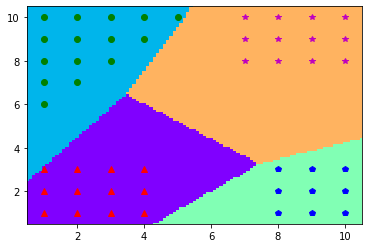

In [95]:
np.random.seed(123)

w, b = perceptron(X, y)
plot(X, y, w, b)

# Q7